In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 디바이스를 사용하여 학습합니다:", device)

# 데이터 전처리 파이프라인 정의
transform = transforms.Compose([transforms.ToTensor()])

# MNIST 데이터셋 로드
dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)

# 데이터셋 크기
dataset_size = len(dataset)

# 데이터셋을 학습 및 검증용으로 분할 (80% 학습, 20% 검증)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 배치 크기 설정
batch_size = 32
test_batch_size = 1000

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)

# 테스트 데이터 로드
test_loader = DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transform),
    batch_size=test_batch_size, shuffle=False
)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # 레이어 정의
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.float()
        h1 = F.relu(self.fc1(x.view(-1, 784)))
        h2 = F.relu(self.fc2(h1))
        h3 = self.fc3(h2)
        return F.log_softmax(h3, dim=1)

def train(log_interval, model, device, train_loader, optimizer, epoch):
    flag = True
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if flag:
            flag = False
            print(target.shape, output.shape)

        if batch_idx % log_interval == 0:
            print('학습 에포크: {} [{}/{} ({:.0f}%)]\t손실: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(log_interval, model, device, test_loader):
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\n테스트 세트: 평균 손실: {:.4f}, 정확도: {}/{} ({:.0f}%)\n'.format
          (test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# 테스트 데이터로 정확도 계산
def compute_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total

# 모델 초기화 및 옵티마이저 설정
model = NeuralNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# 학습 및 테스트 루프
log_interval = 100

for epoch in range(1, 11):  # 10 에포크 동안 학습
    train(log_interval, model, device, train_loader, optimizer, epoch)
    test(log_interval, model, device, test_loader)

# 최종 정확도 출력
final_accuracy = compute_accuracy(model, test_loader, device)
print('최종 정확도:', final_accuracy)



다음 디바이스를 사용하여 학습합니다: cuda
torch.Size([32]) torch.Size([32, 10])
학습 에포크: 1 [0/48000 (0%)]	손실: 2.296518
학습 에포크: 1 [3200/48000 (7%)]	손실: 2.231259
학습 에포크: 1 [6400/48000 (13%)]	손실: 1.983658
학습 에포크: 1 [9600/48000 (20%)]	손실: 1.484676
학습 에포크: 1 [12800/48000 (27%)]	손실: 1.073141
학습 에포크: 1 [16000/48000 (33%)]	손실: 0.621560
학습 에포크: 1 [19200/48000 (40%)]	손실: 0.658528
학습 에포크: 1 [22400/48000 (47%)]	손실: 0.315307
학습 에포크: 1 [25600/48000 (53%)]	손실: 0.278286
학습 에포크: 1 [28800/48000 (60%)]	손실: 0.242845
학습 에포크: 1 [32000/48000 (67%)]	손실: 0.285456
학습 에포크: 1 [35200/48000 (73%)]	손실: 0.523576
학습 에포크: 1 [38400/48000 (80%)]	손실: 0.253308
학습 에포크: 1 [41600/48000 (87%)]	손실: 0.365380
학습 에포크: 1 [44800/48000 (93%)]	손실: 0.318997

테스트 세트: 평균 손실: 0.3390, 정확도: 9011/10000 (90%)

torch.Size([32]) torch.Size([32, 10])
학습 에포크: 2 [0/48000 (0%)]	손실: 0.226997
학습 에포크: 2 [3200/48000 (7%)]	손실: 0.338430
학습 에포크: 2 [6400/48000 (13%)]	손실: 0.321977
학습 에포크: 2 [9600/48000 (20%)]	손실: 0.174673
학습 에포크: 2 [12800/48000 (27%)]	손실: 0.350819
학습 에포크: 2

In [34]:
# 모델 초기화 및 옵티마이저 설정
model = NeuralNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# 학습 및 테스트 루프
log_interval = 100

for epoch in range(1, 11):  # 10 에포크 동안 학습
    train(log_interval, model, device, train_loader, optimizer, epoch)

# 최종 정확도 출력
final_accuracy = compute_accuracy(model, test_loader, device)
print('최종 정확도:', final_accuracy)

# 예측을 위한 예제를 1600개 사용
# DataLoader 설정
test_batch_size = 1600  # 1600개의 예제만 사용하도록 배치 크기 설정

# 테스트 데이터 로드
test_loader = DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transform),
    batch_size=test_batch_size, shuffle=False
)

# 모델을 CUDA 디바이스로 이동 (GPU)
model.to(device)


torch.Size([32]) torch.Size([32, 10])
학습 에포크: 1 [0/48000 (0%)]	손실: 2.298650
학습 에포크: 1 [3200/48000 (7%)]	손실: 2.204576
학습 에포크: 1 [6400/48000 (13%)]	손실: 2.013207
학습 에포크: 1 [9600/48000 (20%)]	손실: 1.395104
학습 에포크: 1 [12800/48000 (27%)]	손실: 0.870494
학습 에포크: 1 [16000/48000 (33%)]	손실: 0.819279
학습 에포크: 1 [19200/48000 (40%)]	손실: 0.771141
학습 에포크: 1 [22400/48000 (47%)]	손실: 0.530684
학습 에포크: 1 [25600/48000 (53%)]	손실: 0.553442
학습 에포크: 1 [28800/48000 (60%)]	손실: 0.599337
학습 에포크: 1 [32000/48000 (67%)]	손실: 0.374516
학습 에포크: 1 [35200/48000 (73%)]	손실: 0.684432
학습 에포크: 1 [38400/48000 (80%)]	손실: 0.278039
학습 에포크: 1 [41600/48000 (87%)]	손실: 0.683201
학습 에포크: 1 [44800/48000 (93%)]	손실: 0.842941
torch.Size([32]) torch.Size([32, 10])
학습 에포크: 2 [0/48000 (0%)]	손실: 0.497289
학습 에포크: 2 [3200/48000 (7%)]	손실: 0.295718
학습 에포크: 2 [6400/48000 (13%)]	손실: 0.371886
학습 에포크: 2 [9600/48000 (20%)]	손실: 0.220601
학습 에포크: 2 [12800/48000 (27%)]	손실: 0.470734
학습 에포크: 2 [16000/48000 (33%)]	손실: 0.320955
학습 에포크: 2 [19200/48000 (40%)]	손실: 0.258

NeuralNetwork(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [35]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 데이터 전처리 파이프라인 정의
transform = transforms.Compose([transforms.ToTensor()])

# MNIST 테스트 데이터셋 로드
test_dataset = datasets.MNIST('../data', train=False, download=True, transform=transform)

# DataLoader 설정
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 모델을 CUDA 디바이스로 이동 (GPU)
model.to(device)

# 예측 수행
def predict(model, test_loader):
    model.eval()  # 모델을 평가 모드로 설정
    predictions = []  # 예측 결과를 저장할 리스트

    with torch.no_grad():
        for data in test_loader:
            images, _ = data  # 테스트 데이터로부터 이미지를 가져옴
            images = images.to(device)  # 이미지를 CUDA 디바이스로 이동
            outputs = model(images)  # 모델에 이미지를 입력하여 예측 수행
            _, predicted = torch.max(outputs, 1)  # 가장 높은 확률을 가진 클래스 선택
            predictions.extend(predicted.cpu().numpy().tolist())  # 예측 결과를 리스트에 추가

    return predictions

# 예측 수행
predictions = predict(model, test_loader)

# 예측 결과 출력 (첫 10개의 예측 결과만 출력)
print(predictions[:10])

# 예측 결과를 numpy 배열로 변환
import numpy as np
predictions_array = np.array(predictions)

# 예측 결과의 형태 확인 (1600개의 예측 결과, 각 예측 결과는 0부터 9까지의 클래스)
print(predictions_array.shape)
print("\n shape of pred=",predictions_array.shape)
# MNIST 테스트 데이터셋 로드
test_dataset = datasets.MNIST('../data', train=False, download=True, transform=transform)

# 테스트 데이터셋의 정답 레이블 가져오기
test_y = test_dataset.targets


[7, 2, 1, 0, 4, 1, 4, 9, 6, 9]
(10000,)

 shape of pred= (10000,)


In [38]:
# 모델 예측 함수 (이미 위에서 정의한 함수를 사용)
predictions = predict(model, test_loader)

# 모델의 예측 결과를 pred 변수에 저장
pred = np.array(predictions)

# 1. 틀린 예제 찾기
wrong = []  # 모델이 틀린 예제의 인덱스를 저장할 리스트
for i in range(len(predictions)):
    if predictions[i] != test_y[i]:  # 모델 예측과 실제 정답이 다른 경우
        wrong.append(i)

# 2. 각 틀린 예제에 대한 정답 클래스 예측 확률 구하기
wr_tg = []  # (예제 인덱스, 정답 클래스 예측 확률) 튜플을 저장할 리스트
for idx in wrong:
    correct_class = test_y[idx]  # 실제 정답 클래스
    prob = pred[idx].item() # Model의 예측 확률
    wr_tg.append((idx, prob))

wnum = len(wrong)
print("wnum=",wnum)

# 3. 정답 클래스 예측 확률을 기준으로 정렬
wr_tg_sorted = sorted(wr_tg, key=lambda x: x[1])

# 4. 최악의 예측 결과 3가지에 대한 결과 출력
num_to_display = 3
for i in range(num_to_display):
    idx, prob = wr_tg_sorted[i]
    img, _ = test_dataset[idx]  # 예제의 이미지 데이터 가져오기
    label = test_y[idx]
    print(f"예측 확률: {prob:.4f}, 정답 레이블: {label}")



wnum= 319
예측 확률: 0.0000, 정답 레이블: 6
예측 확률: 0.0000, 정답 레이블: 6
예측 확률: 0.0000, 정답 레이블: 8


예제 번호: 259
정확한 답변 레이블: 6
모델의 예측 레이블: 0
이 예제의 정확한 답변 클래스 예측 확률: 0.0000000000


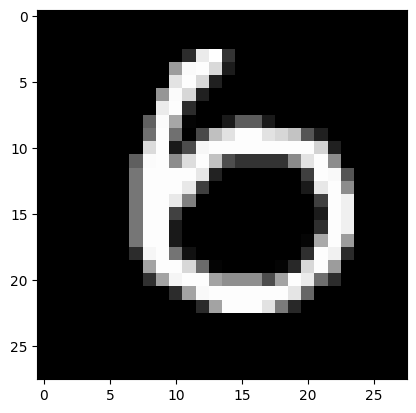

예제 번호: 445
정확한 답변 레이블: 6
모델의 예측 레이블: 0
이 예제의 정확한 답변 클래스 예측 확률: 0.0000000000


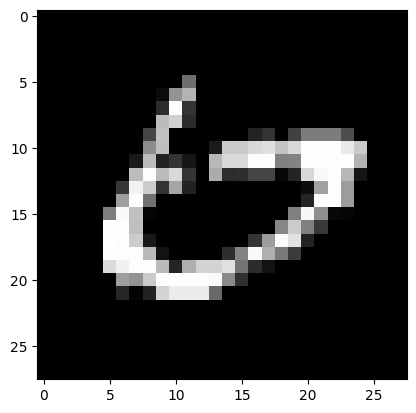

예제 번호: 495
정확한 답변 레이블: 8
모델의 예측 레이블: 0
이 예제의 정확한 답변 클래스 예측 확률: 0.0000000000


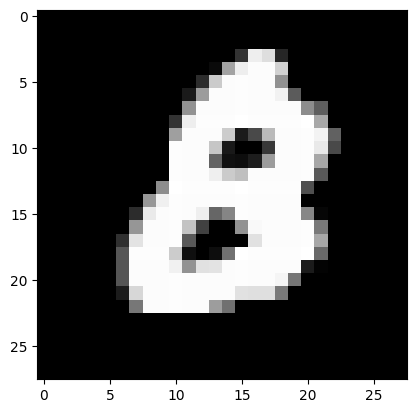

In [31]:
# 1. 예측 결과를 정렬한 배열 res를 만듭니다.
res = sorted(wr_tg, key=lambda x: x[1])

# 2. 상위 n개의 예측 결과를 출력합니다. 이 예제에서는 상위 3개를 출력합니다.
num_to_display = 3
for i in range(num_to_display):
    idx, prob = res[i]
    img, _ = test_dataset[idx] # 예제의 이미지 데이터 가져오기
    label = test_y[idx] # 정확한 답변 레이블 가져오기
    prediction_label = predictions[idx] # 모델의 예측 레이블 가져오기

    # 소수점 10자리까지 표시하는 문자열 포맷 사용
    prob_str = "{:.10f}".format(prob)

    # 출력하기
    print(f"예제 번호: {idx}")
    print(f"정확한 답변 레이블: {label}")
    print(f"모델의 예측 레이블: {prediction_label}")
    print(f"이 예제의 정확한 답변 클래스 예측 확률: {prob_str}")

    # 이미지 출력
    plt.imshow(img.squeeze(), cmap='gray')
    plt.show()
